# DeepLearning Final Proejct

### 1. Problem and Data Introduction

**Challenge Problem**:  
The goal of this Kaggle competition is to detect whether a given text is generated by artificial intelligence. With the rapid development of generative deep learning models (such as GPT-3, BERT, etc.), AI-generated content is becoming increasingly prevalent on the internet. However, such content can be misused, for example, to generate fake news or misleading information. Therefore, developing models that can accurately distinguish between human-written and AI-generated text has become crucial.

**File and Field Information**
*  **{test|train}_essays.csv**
- id - A unique identifier for each essay.
- prompt_id - Identifies the prompt the essay was written in response to.
- text - The essay text itself.
- generated - Whether the essay was **written by a student (0)** or **generated by an LLM (1)**. This field is the target and is not present in test_essays.csv.

*  **train_prompts.csv** - Essays were written in response to information in these fields.

- prompt_id - A unique identifier for each prompt.
- prompt_name - The title of the prompt.
- instructions - The instructions given to students.
- source_text - The text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in 0 Paragraph one.\n\n1 Paragraph two.. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like # Title. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like ## Subheading.


**Data Introduction**:  

- **Training Set**: Contains 1375 student-generated texts and 3 AI-generated texts.
- **Test Set**: Contains the text to be predicted.


**Generative Deep Learning Models**:  
Generative deep learning models (such as GPT-3, BERT, etc.) can produce high-quality text that is grammatically and semantically similar to human-written text. Therefore, the challenge lies in identifying subtle differences to distinguish between human and AI-generated content.

---

### 2. Exploratory Data Analysis (EDA)

**Data Exploration**:  
- **Label Distribution**: The dataset contains 1,375 samples labeled as 0 (student-written) and only 3 samples labeled as 1 (AI-generated), indicating severe class imbalance.
- **Text Length Distribution**: Analysis of text length reveals that student-written texts have a wide range of lengths, while AI-generated texts are relatively shorter.
- **Prompt Sample Count**: The number of samples with different prompts in the dataset is evenly distributed.

**Data Cleaning**:  
- The dataset is probed for missing values and filled in.
- Due to the severe class imbalance, training directly on the raw data would cause the model to favor the majority class (label 0). Therefore, additional AI-generated text samples were introduced to balance the dataset.

**Analysis and Train Plan**:  
- Given the class imbalance, the model training was divided into two parts:
  1. Training on the raw data to observe model performance on imbalanced data.
  2. Introducing additional AI-generated text samples to balance the dataset, retraining the model, and comparing the performance of different models.

---

### 3. Model Architecture

**Model Selection**:  
- **LSTM Model**: Long Short-Term Memory (LSTM) networks are commonly used for sequence modeling and are well-suited for text data. LSTMs can capture long-term dependencies in text sequences, making them suitable for handling texts of varying lengths.
- **CNN Model**: Convolutional Neural Networks (CNNs) also perform well in text classification tasks, as they can capture local features in text through convolutional operations.

**Hyperparameter Tuning**:  
- **LSTM Model**: 128 LSTM units, Adam optimizer, learning rate of 0.001, batch size of 32, and 10 training epochs.

---

### 4. Results and Analysis

**Results Comparison**:  
| Model          | Train Loss | Val Loss | Train Accuracy | Val Accuracy |
|----------------|------------|----------|----------------|--------------|
| Original LSTM  | 0.015786   | 0.017310 | 0.997925       | 0.997585     |
| Combined CNN   | 0.000246   | 0.029491 | 1.000000       | 0.996403     |
| Combined LSTM  | 0.000296   | 0.084944 | 1.000000       | 0.990408     |
| Tuned LSTM     | 0.015306   | 0.017031 | 0.997925       | 0.997585     |

**Hyperparameter Tuning Conclusions**:  
- The **Original LSTM** and **Tuned LSTM** models achieved similar performance, with low training and validation losses and high accuracy, indicating effective learning on the imbalanced dataset.

**Model Performance Analysis**:  
- **LSTM Models**: Both the Original and Tuned LSTM models performed well, with low losses and high accuracy, demonstrating their ability to handle imbalanced data effectively.
- **CNN Model**: While the CNN model achieved perfect training accuracy, its higher validation loss suggests it may struggle with generalization, especially on unseen data.
- **Combined LSTM**: Despite perfect training accuracy, the higher validation loss and lower validation accuracy indicate overfitting, likely due to the complexity of the model.

---

### 5. Conclusion

**Results Recap**:  
- The **Original LSTM** and **Tuned LSTM** models performed well, with low losses and high accuracy, demonstrating their effectiveness on imbalanced data.
- The **Combined CNN** model achieved perfect training accuracy but showed signs of overfitting, as indicated by its higher validation loss.
- The **Combined LSTM** model, while achieving perfect training accuracy, had the highest validation loss and lower validation accuracy, indicating overfitting.

**Learnings and Takeaways**:  
- LSTM models are robust for handling imbalanced text data, achieving high accuracy and low losses.
- CNN models, despite perfect training accuracy, may struggle with generalization without proper regularization.
- Overfitting remains a challenge, particularly when training on balanced datasets with additional samples.

**Ideas for next steps for improvement**:  
- Experiment with advanced architectures like Transformer-based models (e.g., BERT, GPT) for better performance.

# Import

In [44]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoModelForCausalLM, AutoTokenizer

from keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.models import load_model

In [3]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v3.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v5.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v6.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v2.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v1.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7_15_percent_corruption.csv
/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v4.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [4]:
#/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
#/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
#/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
#/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# 加载数据
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
# 加载额外数据
data_train_essays_ext=pd.read_csv('/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v2.csv')


# 查看数据基本信息
print(train_essays.info())
print(test_essays.info())
print(data_train_essays_ext.info())

# 查看前几行数据
print("Original data info:",train_essays.head())
print(train_prompts.head())
print("Extra data info:",data_train_essays_ext.head())

# 合并数据
combined_train_data = pd.concat([train_essays, data_train_essays_ext], ignore_index=True)

# 检查合并后的数据
print("----Combined data info:")
print(combined_train_data.info())
print("----Combined data head:")
print(combined_train_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt_id    1400 non-null   int64 
 1   text         14

In [9]:
# 统计缺失值
print('--Original data--\n',train_essays.isnull().sum())
print('\n--Combined data--\n',combined_train_data.isnull().sum())

--Original data--
 id           0
prompt_id    0
text         0
generated    0
dtype: int64

--Combined data--
 id             1400
prompt_id         0
text              0
generated         0
prompt_name    1378
dtype: int64


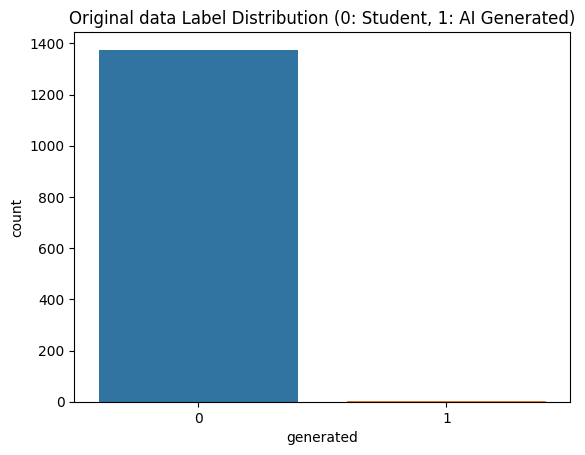

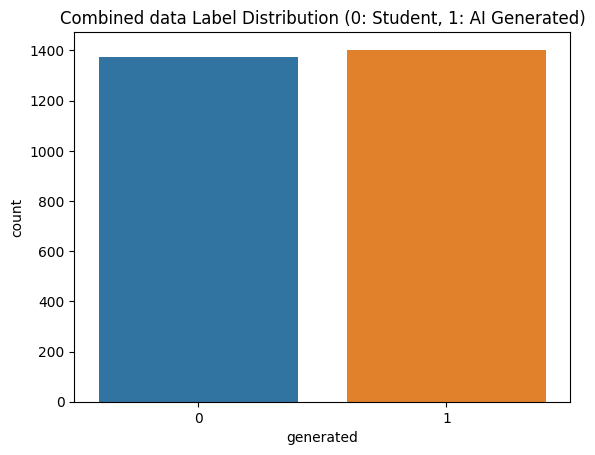

In [6]:
# 标签分布
sns.countplot(x='generated', data=train_essays)
plt.title('Original data Label Distribution (0: Student, 1: AI Generated)')
plt.show()


sns.countplot(x='generated', data=combined_train_data)
plt.title('Combined data Label Distribution (0: Student, 1: AI Generated)')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


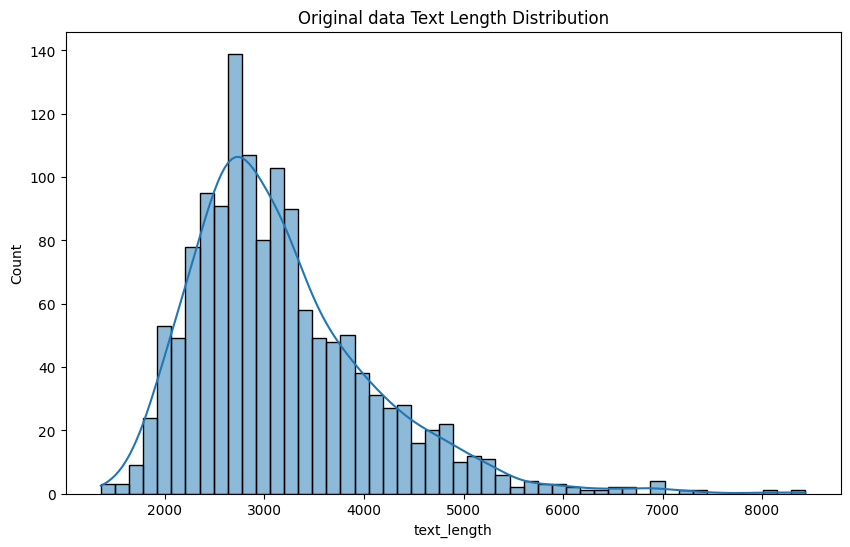

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


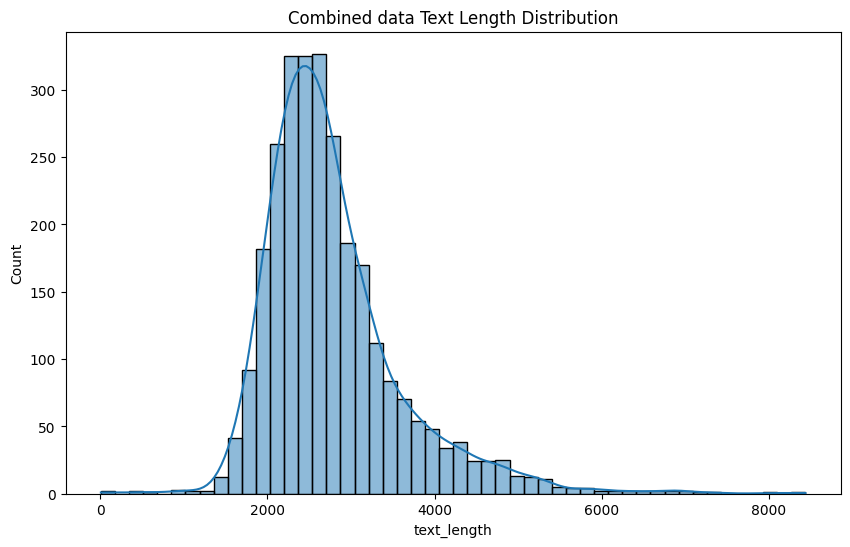

In [10]:
# 计算文本长度
train_essays['text_length'] = train_essays['text'].apply(len)

# 绘制文本长度分布
plt.figure(figsize=(10, 6))
sns.histplot(train_essays['text_length'], bins=50, kde=True)
plt.title('Original data Text Length Distribution')
plt.show()


# 计算文本长度
combined_train_data['text_length'] = combined_train_data['text'].apply(len)

# 绘制文本长度分布
plt.figure(figsize=(10, 6))
sns.histplot(combined_train_data['text_length'], bins=50, kde=True)
plt.title('Combined data Text Length Distribution')
plt.show()


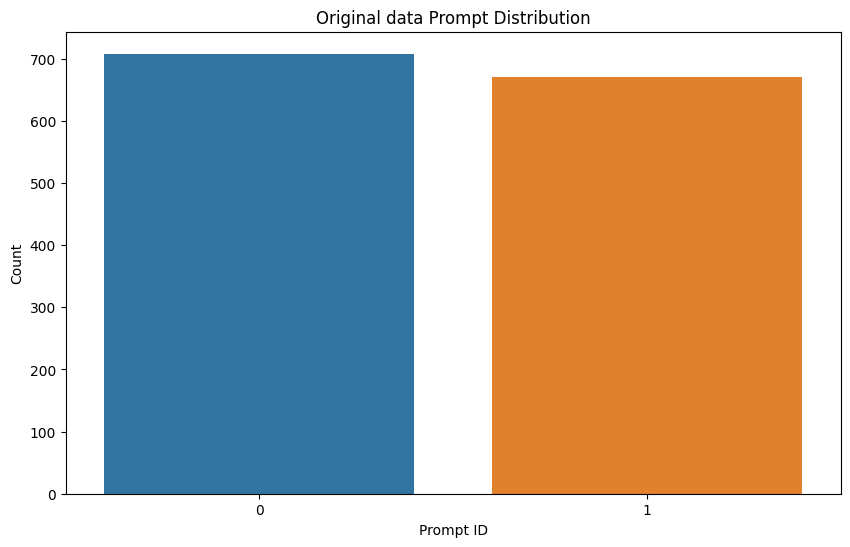

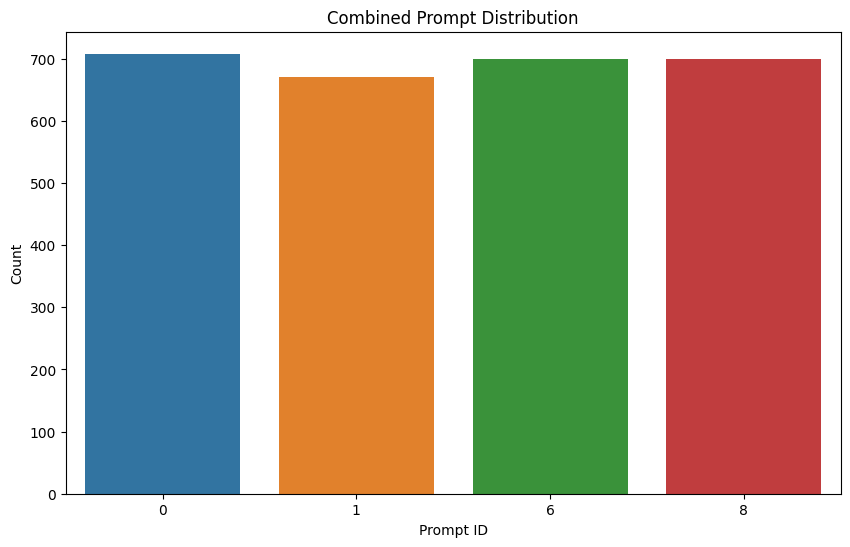

In [14]:
# 每个Prompt的样本数量
org_prompt_counts = train_essays['prompt_id'].value_counts()

# 绘制Prompt分布
plt.figure(figsize=(10, 6))
sns.barplot(x=org_prompt_counts.index, y=org_prompt_counts.values)
plt.title('Original data Prompt Distribution')
plt.xlabel('Prompt ID')
plt.ylabel('Count')
plt.show()


# 每个Prompt的样本数量
comb_prompt_counts = combined_train_data['prompt_id'].value_counts()

# 绘制Prompt分布
plt.figure(figsize=(10, 6))
sns.barplot(x=comb_prompt_counts.index, y=comb_prompt_counts.values)
plt.title('Combined Prompt Distribution')
plt.xlabel('Prompt ID')
plt.ylabel('Count')
plt.show()


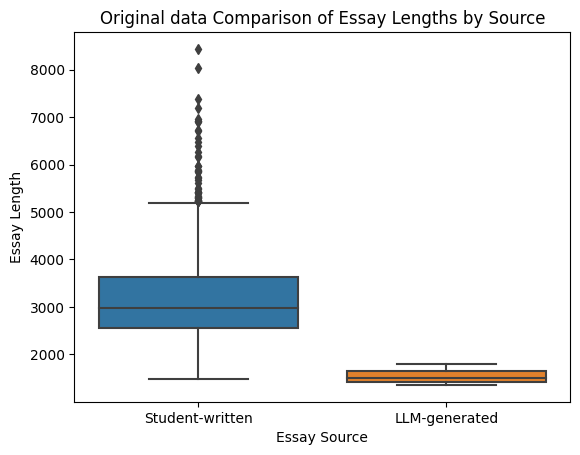

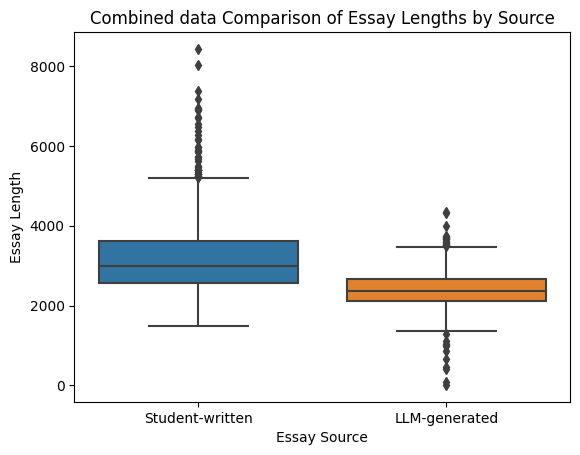

In [16]:
train_essays['essay_length'] = train_essays['text'].apply(len)
sns.boxplot(x='generated', y='essay_length', data=train_essays)
plt.title('Original data Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()


combined_train_data['essay_length'] = combined_train_data['text'].apply(len)
sns.boxplot(x='generated', y='essay_length', data=combined_train_data)
plt.title('Combined data Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

# Part 1 -- Use Original data

**Parameter initialization**

In [20]:
# 划分训练集和验证集
org_train_df, org_val_df = train_test_split(train_essays, test_size=0.3, random_state=42, stratify=train_essays['generated'])
# 检查划分后的数据
print(f"Original data Training set size: {len(org_train_df)}")
print(f"Original data Validation set size: {len(org_val_df)}")

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# 查看分词器的词汇表大小
vocab_size = tokenizer.vocab_size
print(f"\nTokenizer vocab size: {vocab_size}")

# 定义分词函数
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# 转换为 Hugging Face Dataset 格式
org_train_dataset = Dataset.from_pandas(org_train_df)
org_val_dataset = Dataset.from_pandas(org_val_df)
# 对训练集和验证集进行分词
org_tokenized_train = org_train_dataset.map(tokenize_function, batched=True)
org_tokenized_val = org_val_dataset.map(tokenize_function, batched=True)

# 检查分词后的数据
print(f"\nTokenized train size: {len(org_tokenized_train)}")
print(f"Tokenized val size: {len(org_tokenized_val)}")

# 提取 input_ids 和标签
X_org_train = np.array([example['input_ids'] for example in org_tokenized_train])
y_org_train = np.array([example['generated'] for example in org_tokenized_train])
X_org_val = np.array([example['input_ids'] for example in org_tokenized_val])
y_org_val = np.array([example['generated'] for example in org_tokenized_val])

# 检查数据形状和类型
print(f"\nX_train shape: {X_org_train.shape}, dtype: {X_org_train.dtype}")
print(f"y_train shape: {y_org_train.shape}, dtype: {y_org_train.dtype}")
print(f"X_val shape: {X_org_val.shape}, dtype: {X_org_val.dtype}")
print(f"y_val shape: {y_org_val.shape}, dtype: {y_org_val.dtype}")

# 将超出范围的值截断为 vocab_size - 1
X_org_train = np.clip(X_org_train, 0, vocab_size - 1)
X_org_val = np.clip(X_org_val, 0, vocab_size - 1)

# 再次检查 X_train 和 X_val 的范围
print(f"\nX_train min (after clipping): {np.min(X_org_train)}, max: {np.max(X_org_train)}")
print(f"X_val min (after clipping): {np.min(X_org_val)}, max: {np.max(X_org_val)}")

Original data Training set size: 964
Original data Validation set size: 414


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Tokenizer vocab size: 30522


Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]


Tokenized train size: 964
Tokenized val size: 414

X_train shape: (964, 64), dtype: int64
y_train shape: (964,), dtype: int64
X_val shape: (414, 64), dtype: int64
y_val shape: (414,), dtype: int64

X_train min (after clipping): 101, max: 29578
X_val min (after clipping): 101, max: 29536


**The LSTM model is built with the original data**

In [22]:
# 构建LSTM模型
org_model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
org_model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
org_lstm = org_model_lstm.fit(X_org_train, y_org_train, epochs=10, batch_size=32, validation_data=(X_org_val, y_org_val))

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9273 - loss: 0.4392 - val_accuracy: 0.9976 - val_loss: 0.0177
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9990 - loss: 0.0093 - val_accuracy: 0.9976 - val_loss: 0.0181
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9990 - loss: 0.0090 - val_accuracy: 0.9976 - val_loss: 0.0178
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9977 - loss: 0.0164 - val_accuracy: 0.9976 - val_loss: 0.0178
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9977 - loss: 0.0182 - val_accuracy: 0.9976 - val_loss: 0.0174
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9995 - loss: 0.0053 - val_accuracy: 0.9976 - val_loss: 0.0178
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9995 - loss: 0.0056 - val_accuracy: 0.9976 - val_loss: 0.0175
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9989 - loss: 0.0093 - val_accuracy: 0.9976 - v

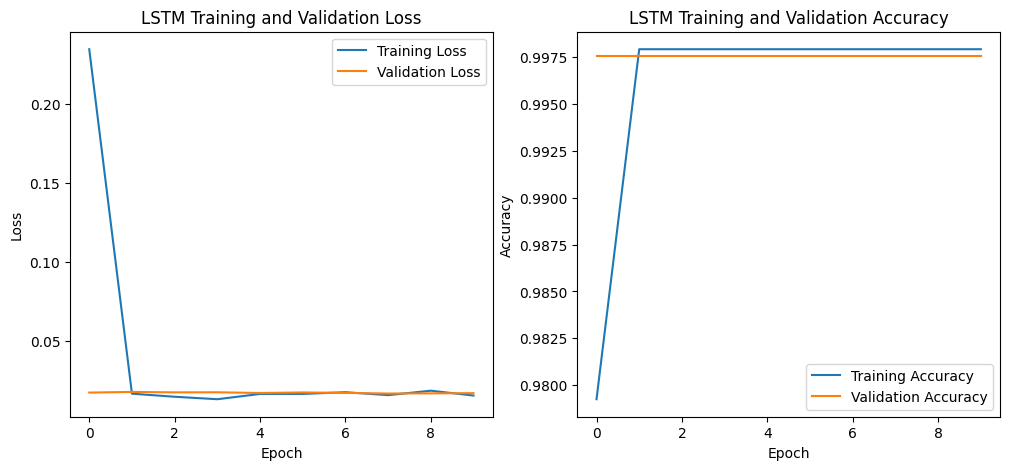

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       0.00      0.00      0.00         1

    accuracy                           1.00       414
   macro avg       0.50      0.50      0.50       414
weighted avg       1.00      1.00      1.00       414

LSTM模型架构 Validation Accuracy: 0.9976
Confusion Matrix:
[[413   0]
 [  1   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(org_lstm.history['loss'], label='Training Loss')
plt.plot(org_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(org_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(org_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.show()


# 评估模型
y_org_pred = (org_model_lstm.predict(X_org_val) > 0.5).astype(int)
print(classification_report(y_org_val, y_org_pred))

org_lstm_accuracy = org_lstm.history['val_accuracy'][-1]
print(f"LSTM模型架构 Validation Accuracy: {org_lstm_accuracy:.4f}")


# 如果需要，你还可以输出混淆矩阵
conf_matrix = confusion_matrix(y_org_val, y_org_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Part 2 -- Use Combined data

In [29]:
# Parameter initialization

# 划分训练集和验证集
train_df, val_df = train_test_split(combined_train_data, test_size=0.3, random_state=42, stratify=combined_train_data['generated'])

# 检查划分后的数据
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# 查看分词器的词汇表大小
vocab_size = tokenizer.vocab_size
print(f"\nTokenizer vocab size: {vocab_size}")

# 定义分词函数
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# 转换为 Hugging Face Dataset 格式
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
# 对训练集和验证集进行分词
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

# 检查分词后的数据
print(f"\nTokenized train size: {len(tokenized_train)}")
print(f"Tokenized val size: {len(tokenized_val)}")

# 提取 input_ids 和标签
X_train = np.array([example['input_ids'] for example in tokenized_train])
y_train = np.array([example['generated'] for example in tokenized_train])
X_val = np.array([example['input_ids'] for example in tokenized_val])
y_val = np.array([example['generated'] for example in tokenized_val])

# 检查数据形状和类型
print(f"\nX_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"X_val shape: {X_val.shape}, dtype: {X_val.dtype}")
print(f"y_val shape: {y_val.shape}, dtype: {y_val.dtype}")

# 将超出范围的值截断为 vocab_size - 1
X_train = np.clip(X_train, 0, vocab_size - 1)
X_val = np.clip(X_val, 0, vocab_size - 1)

# 再次检查 X_train 和 X_val 的范围
print(f"\nX_train min (after clipping): {np.min(X_train)}, max: {np.max(X_train)}")
print(f"X_val min (after clipping): {np.min(X_val)}, max: {np.max(X_val)}")

Training set size: 1944
Validation set size: 834

Tokenizer vocab size: 30522


Map:   0%|          | 0/1944 [00:00<?, ? examples/s]

Map:   0%|          | 0/834 [00:00<?, ? examples/s]


Tokenized train size: 1944
Tokenized val size: 834

X_train shape: (1944, 64), dtype: int64
y_train shape: (1944,), dtype: int64
X_val shape: (834, 64), dtype: int64
y_val shape: (834,), dtype: int64

X_train min (after clipping): 0, max: 29578
X_val min (after clipping): 0, max: 29536


# 模型1：CNN Model

In [31]:
# 构建 1D CNN 模型
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 打印模型摘要
model_cnn.summary()

# 训练模型
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7705 - loss: 0.5437 - val_accuracy: 0.9940 - val_loss: 0.0307
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9983 - loss: 0.0139 - val_accuracy: 0.9964 - val_loss: 0.0246
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9964 - val_loss: 0.0244
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9991 - loss: 0.0096 - val_accuracy: 0.9964 - val_loss: 0.0227
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9964 - val_loss: 0.0239
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 7.6431e-04 - val_accuracy: 0.9964 - val_loss: 0.0251
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 3.9334e-04 - val_accuracy: 0.9964 - val_loss: 0.0263
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 4.3018e-04 - val_accuracy

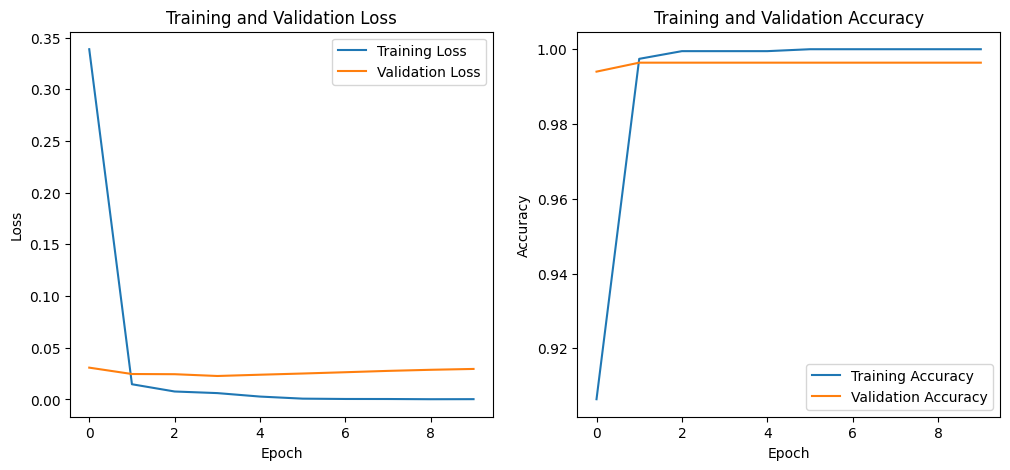

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0501 
CNN Validation Accuracy: 0.9964
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00       421

    accuracy                           1.00       834
   macro avg       1.00      1.00      1.00       834
weighted avg       1.00      1.00      1.00       834

Confusion Matrix:
[[412   1]
 [  2 419]]


In [34]:
# 可视化训练结果
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# 评估模型
cnn_val_loss, cnn_val_accuracy = model_cnn.evaluate(X_val, y_val)
print(f"CNN Validation Accuracy: {cnn_val_accuracy:.4f}")

# 评估模型
y_pred = (model_cnn.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))



# 如果需要，你还可以输出混淆矩阵
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 模型2：LSTM Model

In [36]:
# 构建LSTM模型
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7460 - loss: 0.5336 - val_accuracy: 0.9796 - val_loss: 0.0993
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9944 - loss: 0.0428 - val_accuracy: 0.9880 - val_loss: 0.0631
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9990 - loss: 0.0115 - val_accuracy: 0.9880 - val_loss: 0.0698
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9989 - loss: 0.0095 - val_accuracy: 0.9916 - val_loss: 0.0605
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.9904 - val_loss: 0.0634
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9916 - val_loss: 0.0619
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 1.0000 - loss: 8.6542e-04 - val_accuracy: 0.9904 - val_loss: 0.0737
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 1.0000 - loss: 6.0872e-04 - val_accuracy: 0.9904 - val_

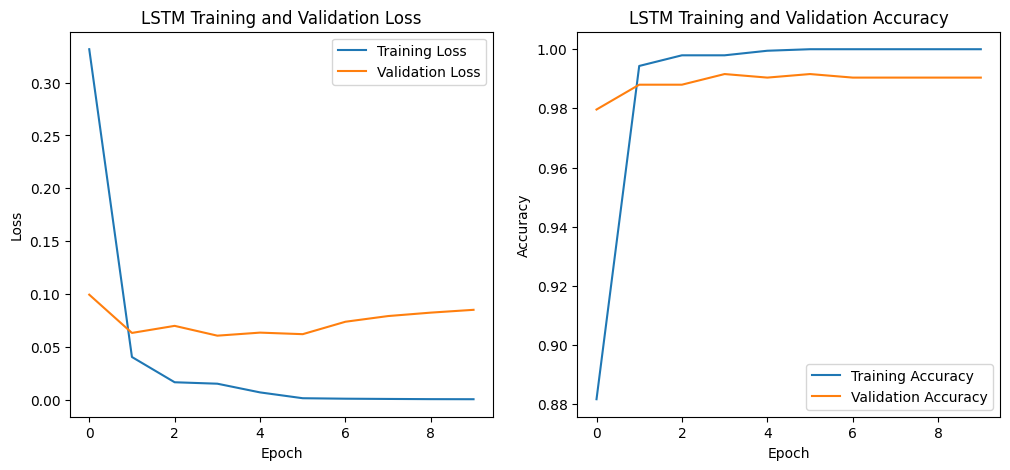

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       413
           1       0.99      0.99      0.99       421

    accuracy                           0.99       834
   macro avg       0.99      0.99      0.99       834
weighted avg       0.99      0.99      0.99       834

LSTM模型架构 Validation Accuracy: 0.9904


In [40]:
# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.show()


# 评估模型
y_pred = (model_lstm.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))


lstm1_accuracy = history_lstm.history['val_accuracy'][-1]
print(f"LSTM模型架构 Validation Accuracy: {lstm1_accuracy:.4f}")

# Hyperparameter tuning

In [43]:


# 定义模型构建函数
def build_model(hp):
    model = Sequential()
    
    # 超参数：Embedding 层的输出维度
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=64))
    
    # 超参数：LSTM 单元数
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units, return_sequences=False))
    
    # 超参数：Dropout 率
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    # 输出层
    model.add(Dense(1, activation='sigmoid'))
    
    # 超参数：学习率
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 初始化 Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # 优化目标为验证集准确率
    max_trials=10,             # 最大尝试次数
    executions_per_trial=2,    # 每个超参数组合训练 2 次以减少随机性
    directory='keras_tuner_dir',  # 保存结果的目录
    project_name='lstm_tuning'    # 项目名称
)

# 开始超参数搜索
tuner.search(
    X_org_train, y_org_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_org_val, y_org_val),
    verbose=2
)

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Embedding dim: {best_hps.get('embedding_dim')}
- LSTM units: {best_hps.get('lstm_units')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# 使用最佳超参数训练最终模型
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_org_train, y_org_train,
    epochs=20,  # 可以增加训练轮数
    batch_size=32,
    validation_data=(X_org_val, y_org_val),
    verbose=2
)

# 评估最佳模型在验证集上的性能
val_loss, val_accuracy = best_model.evaluate(X_org_val, y_org_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.9975845217704773

Best val_accuracy So Far: 0.9975845217704773
Total elapsed time: 00h 08m 58s

Best hyperparameters:
- Embedding dim: 64
- LSTM units: 128
- Dropout rate: 0.3
- Learning rate: 0.0001

Epoch 1/20
31/31 - 5s - 159ms/step - accuracy: 0.9772 - loss: 0.6676 - val_accuracy: 0.9976 - val_loss: 0.6280
Epoch 2/20
31/31 - 2s - 76ms/step - accuracy: 0.9979 - loss: 0.4259 - val_accuracy: 0.9976 - val_loss: 0.0195
Epoch 3/20
31/31 - 2s - 78ms/step - accuracy: 0.9979 - loss: 0.0146 - val_accuracy: 0.9976 - val_loss: 0.0171
Epoch 4/20
31/31 - 2s - 76ms/step - accuracy: 0.9979 - loss: 0.0156 - val_accuracy: 0.9976 - val_loss: 0.0172
Epoch 5/20
31/31 - 2s - 77ms/step - accuracy: 0.9979 - loss: 0.0152 - val_accuracy: 0.9976 - val_loss: 0.0171
Epoch 6/20
31/31 - 2s - 77ms/step - accuracy: 0.9979 - loss: 0.0158 - val_accuracy: 0.9976 - val_loss: 0.0172
Epoch 7/20
31/31 - 3s - 85ms/step - accuracy: 0.9979 - loss: 0.0163 - val_accuracy: 0.9976

# Comparison of model effects

In [48]:
# 创建性能对比表格
performance_table = pd.DataFrame({
    'Model': ['Original LSTM', 'Combined CNN', 'Combined LSTM', 'Tuned LSTM'],
    'Train Loss': [
        org_lstm.history['loss'][-1],
        history_cnn.history['loss'][-1],
        history_lstm.history['loss'][-1],
        history.history['loss'][-1]
    ],
    'Val Loss': [
        org_lstm.history['val_loss'][-1],
        history_cnn.history['val_loss'][-1],
        history_lstm.history['val_loss'][-1],
        history.history['val_loss'][-1]
    ],
    'Train Accuracy': [
        org_lstm.history['accuracy'][-1],
        history_cnn.history['accuracy'][-1],
        history_lstm.history['accuracy'][-1],
        history.history['accuracy'][-1]
    ],
    'Val Accuracy': [
        org_lstm.history['val_accuracy'][-1],
        history_cnn.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        history.history['val_accuracy'][-1]
    ]
})

print(performance_table)

           Model  Train Loss  Val Loss  Train Accuracy  Val Accuracy
0  Original LSTM    0.015786  0.017310        0.997925      0.997585
1   Combined CNN    0.000246  0.029491        1.000000      0.996403
2  Combined LSTM    0.000296  0.084944        1.000000      0.990408
3     Tuned LSTM    0.015306  0.017031        0.997925      0.997585


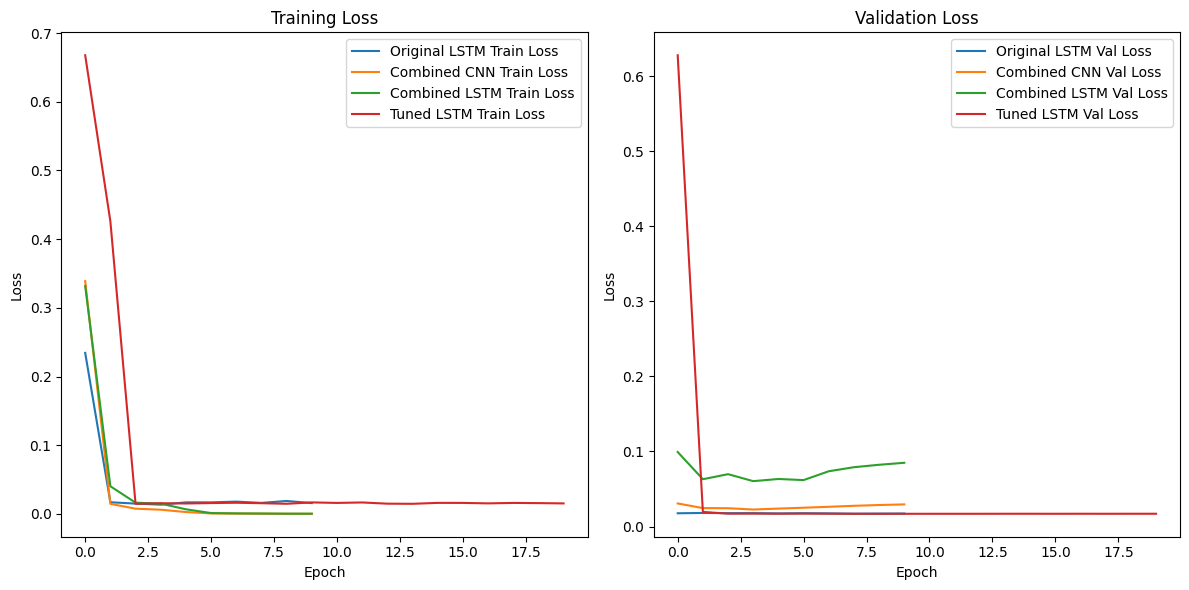

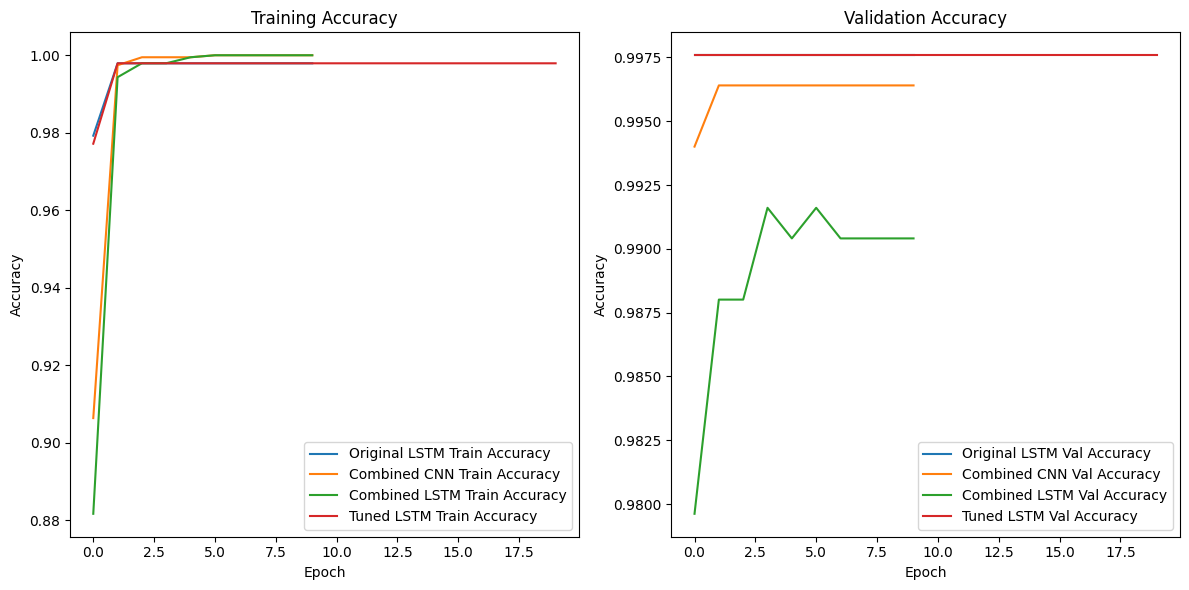

In [49]:
# 假设你已经有了四个模型的训练历史记录
# org_lstm: 原始数据训练的LSTM模型的历史记录
# history_cnn: 组合数据训练的CNN模型的历史记录
# history_lstm: 组合数据训练的LSTM模型的历史记录
# history: 超参数调整模型的历史记录

# 绘制训练和验证的损失曲线
plt.figure(figsize=(12, 6))

# 训练损失
plt.subplot(1, 2, 1)
plt.plot(org_lstm.history['loss'], label='Original LSTM Train Loss')
plt.plot(history_cnn.history['loss'], label='Combined CNN Train Loss')
plt.plot(history_lstm.history['loss'], label='Combined LSTM Train Loss')
plt.plot(history.history['loss'], label='Tuned LSTM Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 验证损失
plt.subplot(1, 2, 2)
plt.plot(org_lstm.history['val_loss'], label='Original LSTM Val Loss')
plt.plot(history_cnn.history['val_loss'], label='Combined CNN Val Loss')
plt.plot(history_lstm.history['val_loss'], label='Combined LSTM Val Loss')
plt.plot(history.history['val_loss'], label='Tuned LSTM Val Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制训练和验证的准确率曲线
plt.figure(figsize=(12, 6))

# 训练准确率
plt.subplot(1, 2, 1)
plt.plot(org_lstm.history['accuracy'], label='Original LSTM Train Accuracy')
plt.plot(history_cnn.history['accuracy'], label='Combined CNN Train Accuracy')
plt.plot(history_lstm.history['accuracy'], label='Combined LSTM Train Accuracy')
plt.plot(history.history['accuracy'], label='Tuned LSTM Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 验证准确率
plt.subplot(1, 2, 2)
plt.plot(org_lstm.history['val_accuracy'], label='Original LSTM Val Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Combined CNN Val Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Combined LSTM Val Accuracy')
plt.plot(history.history['val_accuracy'], label='Tuned LSTM Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Export File

In [ ]:
# 数据预处理（假设我们使用与训练数据相同的文本预处理方式）
# 如果你已经有训练时使用的 Tokenizer 和最大词汇表大小，你可以直接加载它们
tokenizer = Tokenizer(num_words=5000)  # 你可以根据训练时的参数进行调整
tokenizer.fit_on_texts(test_essays['text'])  # 假设你使用相同的训练数据的 tokenizer

# 转换文本为序列
test_sequences = tokenizer.texts_to_sequences(test_essays['text'])
test_data_padded = pad_sequences(test_sequences, maxlen=1000)  # 设置maxlen为训练时的值


# 进行预测
predictions = model_lstm.predict(test_data_padded)

# 生成提交文件
submission = pd.DataFrame({
    'id': test_essays['id'],  # 从测试数据中获取id
    'generated': predictions.flatten()  # 将预测结果展平并与id对应
})

# 保存为 CSV 文件
submission.to_csv('submission.csv', index=False)

print("提交文件已生成：submission.csv")

In [ ]:
submission.head()